I will use this notebook to demonstrate some calculations of photon emission properties from a nanofiber-trapped neutral atom system using MEEP and plotting in Julia.

In [1]:
run(pipeline(`mpirun -n 6 meep-mpi "nanofiber.ctl"`, "nanofiber.out"))


Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecate

# Local field evolution

This should be obtained by setting up a point-monitor at the dipole position and append time-dependent field components in some short periods. 
The data is stored in the `nanofiber-Ert.h5` file.
Now we plot out the time-dependent evolution of the field at the dipole position.

In [2]:
run(`h5ls nanofiber-Ert.h5`)

ex.i                     Dataset {1200/Inf}
ex.r                     Dataset {1200/Inf}
ey.i                     Dataset {1200/Inf}
ey.r                     Dataset {1200/Inf}
ez.i                     Dataset {1200/Inf}
ez.r                     Dataset {1200/Inf}


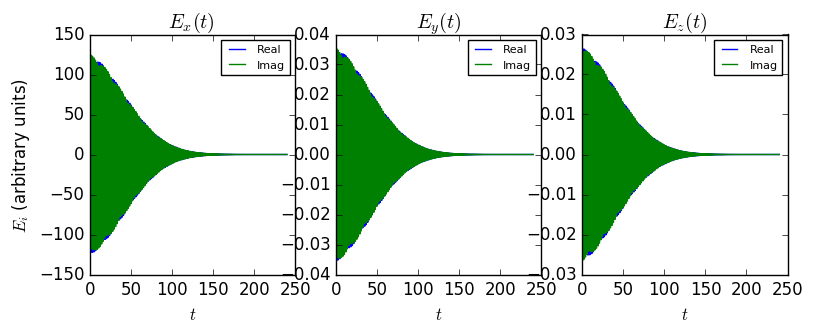

1
(1200,)


PyObject <matplotlib.legend.Legend object at 0x7f3c1bffbbd0>

In [3]:
using PyPlot
using HDF5
ex = h5read("nanofiber-Ert.h5", "ex.r") + im*h5read("nanofiber-Ert.h5", "ex.i")
ey = h5read("nanofiber-Ert.h5", "ey.r") + im*h5read("nanofiber-Ert.h5", "ey.i")
ez = h5read("nanofiber-Ert.h5", "ez.r") + im*h5read("nanofiber-Ert.h5", "ez.i")
println(ndims(ex)) # Print out the dimension of the variables to check if it's a vector (output 1). Otherwise, use permutedims to flip the data dimension.
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
println(size(ex))
lent=length(ex)
t=linspace(0,240.0,lent)
figure(figsize=(9,3))
subplot(1,3,1)
ax=plot(t,real(ex))
plot(t,imag(ex))
title("\$E_x(t)\$ ")
xlabel(L"t")
ylabel(L"$E_i$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
ax=plot(t,real(ey))
plot(t,imag(ey))
title("\$E_y(t)\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
ax=plot(t,real(ez))
plot(t,imag(ez))
title("\$E_z(t)\$")
xlabel(L"t")
#ylabel(L"$E_z$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Now we can plot out the detected signal in the frequency domain correspondingly.

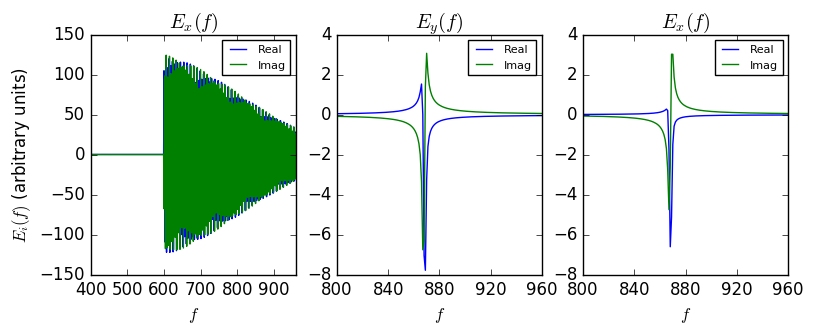

PyObject <matplotlib.legend.Legend object at 0x7f3c1b694150>

In [4]:
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
ex_f=fftshift(ex); ey_f=fftshift(ey_f); ez_f=fftshift(ez_f); # Have to shift the frequency domain data for complex singal. See: http://www.exegetic.biz/blog/2015/10/monthofjulia-day-37-fourier-techniques/ 
figure(figsize=(9,3))
subplot(1,3,1)
plot(real(ex_f))
plot(imag(ex_f))
xlabel(L"f")
xlim([400,960])
ylabel(L"$E_i(f)$ (arbitrary units)")
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
plot(real(ey_f))
plot(imag(ey_f))
xlabel(L"f")
xlim([800,960])
xticks(linspace(800,960,5))
title("\$E_y(f)\$")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
plot(real(ez_f))
plot(imag(ez_f))
xlabel(L"f")
xlim([800,960])
xticks(linspace(800,960,5))
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=8)

It becomes tricky now to tranvert the unit of frequency in MEEP to a normal scale. I am not sure about this part for now. See the dipole signal below.

## The time-evolution of the dipole source
To calculate the Green function at the dipole position, we need to use the time-evolution of the dipole source which is essentially described by the following function
$$E_i = E_0 \exp{\left[-i\omega t-\frac{(t-t_0)^2}{2w^2}\right]},$$
where $w=\frac{1}{df}$ is the time width of the signal and $df$ is the frequency width in the special units defined by MEEP. In the simulation script, the center of time $t_0$ is defined by 
$t_0=t_{start}+\Delta t_{cutoff}$ with the starting time $t_{start}=0$ and the cutoff time $t_{cutoff}=5$ by default. So, the signal of the input component will look like the following.

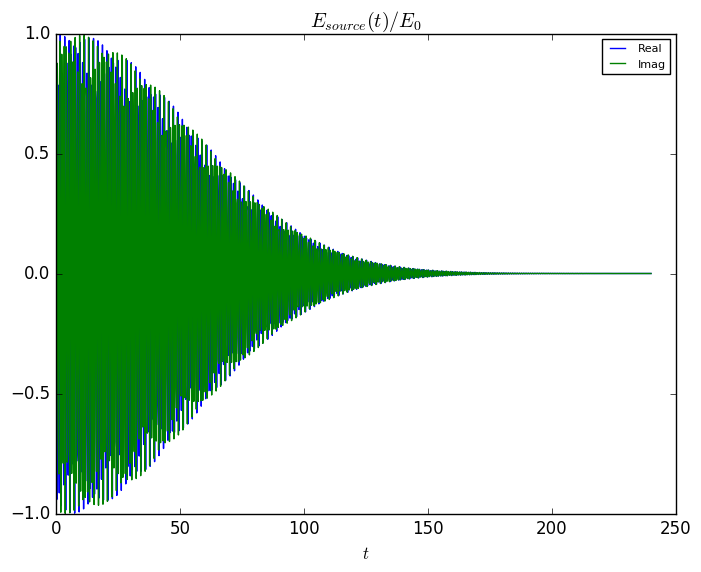

PyObject <matplotlib.legend.Legend object at 0x7f3c1b379810>

In [5]:
df=0.02; w=1/df;
ω=2.*pi/0.895 # in MEEP, we have c=1, lambda=0.895.
t_cutoff=5; t_0=t_cutoff;
E_source=exp(-im*ω*t-(t-t_0).^2/2./w^2)
figure;
plot(t,real(E_source))
plot(t,imag(E_source))
title("\$E_{source}(t)/E_0\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Now, let's look at the signal in the frequency domain.

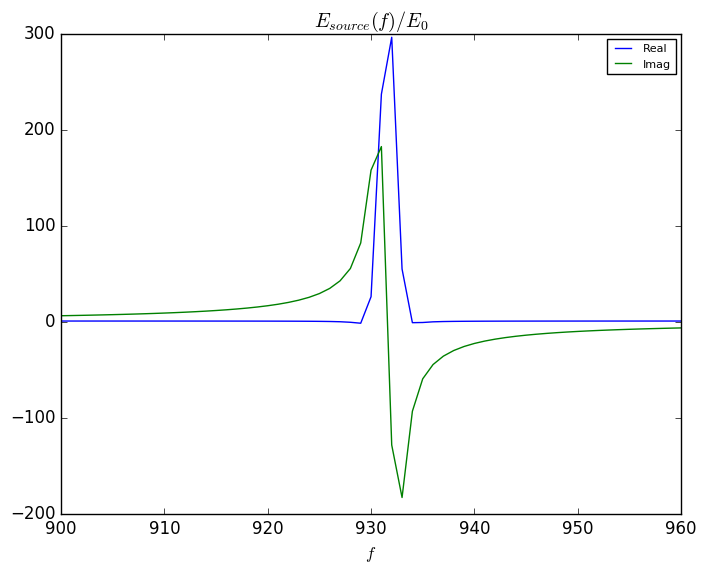

PyObject <matplotlib.legend.Legend object at 0x7f3c1b2c8810>

In [6]:
E_source_f = fft(E_source)
#E_source_f = fftshift(E_source_f) # Shift the data as before.
figure;
plot(real(E_source_f))
plot(imag(E_source_f))
title("\$E_{source}(f)/E_0\$")
xlabel(L"f")
xlim([900,960])
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Again, to convert the unit of frequency to the normal scale becomes tricky. I need to think about it more carefully. 

Also, I didn't use the `fftshift()` function for this transformation, in which I should. The signal in MEEP is a complex function and is different from many other software. To be continued...